# Slides for week 1 of PREM 4 DERG

This is a set of slides and code for week 1 of the PREM for DERG sessions.
It is a slide show to introduce PREM, to get people thinking, and to have some
code to play with.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

# have you cited PREM?

# What is PREM

$$ M = 4\pi \int_0^{R_{e}} \rho(r) r^2 \,\mathrm{d}r.$$

In [2]:
# Show PREM plots

In [3]:
class PeicewisePolynomial(object):
    """
    Peicewise Polynomials a different way
    
    The SciPy PPoly class defines a function from
    polynomials with coefficents c and breakpoints x
    evaluated at a point xp thus:
    
       S = sum(c[m, i] * (xp - x[i])**(k-m) for m in range(k+1))
    
    This is not helpful for PREM, so we create a new class defining
    the function:
    
       S = sum(c[m, i] * (xp - x[i])**(k-m) for m in range(k+1))
      
    Note some important differences between this and PPoly!
    """
    
    def __init__(self, c, x):
        self.breakpoints = x 
        self.coeffs = c
        
        
    def __call__(self, xp, break_down=False):
        if np.ndim(xp) == 0:
            value = self._evaluate_at_point(xp, break_down)
        else:
            value = np.zeros_like(xp)
            for i in range(xp.size):
                value[i] = self._evaluate_at_point(xp[i], break_down)
        return value        
        
        
    def _evaluate_at_point(self, x, break_down=False):
        """
        Evaluate peicewise polynomal at point x
        """
        coef = self._get_coefs(x, break_down)
        value = self._evaluate_polynomial(x, coef)
        return value
        
        
    def _evaluate_polynomial(self, x, coef):
        value = 0
        for i, c in enumerate(coef):
            value = value + c * x**i
        return value
        
        
    def _get_coefs(self, x, break_down=False):
        """
        Return coefs at x
        
        If x falls on a breakpoint, we take the coeffecents from 
        'above' the breakpoint. Unless break_down is True, in which
        case we take the coeffecents from 'below'
        """
        if x == self.breakpoints[-1]:
            # We use the last coefficents for the outside point
            return self.coeffs[-1,:]
        if break_down:
            for i in range(self.breakpoints.size):
                if (x > self.breakpoints[i]) and (x <= self.breakpoints[i+1]):
                    return self.coeffs[i,:]
        else:
            for i in range(self.breakpoints.size):
                if (x >= self.breakpoints[i]) and (x < self.breakpoints[i+1]):
                    return self.coeffs[i,:]
        
        return None
    
    
    def derivative(self):
    
        deriv_breakpoints = self.breakpoints
        deriv_coeffs = np.zeros((self.coeffs.shape[0], self.coeffs.shape[1]-1))
        for seg in range(self.coeffs.shape[0]):
            for i in range(self.coeffs.shape[1]):
                if i == 0:
                    continue # Throw away term for x**0
                deriv_coeffs[seg,i-1] = self.coeffs[seg,i]*i
                
        deriv = PeicewisePolynomial(deriv_coeffs, deriv_breakpoints)
        return deriv
    
    def antiderivative(self):
        
        antideriv_breakpoints = self.breakpoints
        antideriv_coeffs = np.zeros((self.coeffs.shape[0], self.coeffs.shape[1]+1))
        for seg in range(self.coeffs.shape[0]):
            for i in range(self.coeffs.shape[1]):
                antideriv_coeffs[seg,i+1] = self.coeffs[seg,i]/(i+1)
                
        antideriv = PeicewisePolynomial(antideriv_coeffs, antideriv_breakpoints)
        return antideriv
    
    
    def integrate(self, a, b):
        
        #antiderivative = self.antiderivative()
        integral = 0
        lower_bound = a
        for bpi, bp in enumerate(self.breakpoints):
            if bp > lower_bound:
                if self.breakpoints[bpi] >= b:
                    # Just the one segment left - add it and end
                    integral = integral + (self(b, break_down=True) - self(lower_bound))
                    #print(integral, lower_bound, b, 'done')
                    break
                else:
                    # segment from lower bound to bp
                    # add it, increment lower_bound and contiue
                    integral = integral + (self(bp, break_down=True) - self(lower_bound))
                    #print(integral, lower_bound, bp)
                    lower_bound = bp

        return integral
    
    
    def mult(self, other):
        assert self.coeffs.shape[0] == other.coeffs.shape[0], 'different number of breakpoints'
        mult_breakpoints = self.breakpoints
        mult_coefs = np.zeros((self.coeffs.shape[0], self.coeffs.shape[1]+other.coeffs.shape[1]))
        for seg in range(self.coeffs.shape[0]):
            for i in range(self.coeffs.shape[1]):
                for j in range(other.coeffs.shape[1]):
                    mult_coefs[seg,i+j] = mult_coefs[seg,i+j] + self.coeffs[seg,i]*other.coeffs[seg,j]
                    
        mult_poly = PeicewisePolynomial(mult_coefs, mult_breakpoints)
        return mult_poly

In [4]:
class Prem(object):
    
    def __init__(self, breakpoints, density_params, r_earth=6371):
        
        self.r_earth = r_earth
        
        self.density_poly = PeicewisePolynomial(density_params, 
                                           breakpoints)
        
    def density(self, r):
        """
        Evaluate density in kg/m**3 at radii r (in km)
        """
        return self.density_poly(r)


In [5]:
# This implements the PREM density model using 



# Polynomial coefficents for PREM density. 
# Note that the array is transposed to match 
# what Scipy's PPoly needs.

r_earth = 6371 # km

density_params = np.array([[13.0885,  0.0000, -8.8381,  0.0000],
                           [12.5815, -1.2638, -3.6426, -5.5281],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [5.3197, -1.4836,  0.0000,  0.0000],
                           [11.2494, -8.0298,  0.0000,  0.0000],
                           [7.1089, -3.8045,  0.00002,  0.0000],
                           [2.6910,  0.6924,  0.0000,  0.0000],
                           [2.6910,  0.6924,  0.0000,  0.0000],
                           [2.9000,  0.0000,  0.0000,  0.0000],
                           [2.6000,  0.0000,  0.0000,  0.0000],
                           [1.0200,  0.0000,  0.0000,  0.0000]])


# Turn range of polynomials from 0 - 1 to 0 - r_earth (makes mass easer) 
density_params[:,0] = density_params[:,0] * 1000
density_params[:,1] = (density_params[:,1] * 1000) / r_earth 
density_params[:,2] = (density_params[:,2] * 1000) / (r_earth**2)
density_params[:,3] = (density_params[:,3] * 1000) / (r_earth**3)


# All 14 discontiuities in PREM in km.
breakpoints = np.array([0.0, 1221.5, 3480.0, 3630.0, 5600.0, 5701.0, 5771.0,
                        5971.0, 6151.0, 6291.0, 6346.6, 6356.0, 6368.0, 6371.0])



prem = Prem(breakpoints, density_params, r_earth=r_earth)

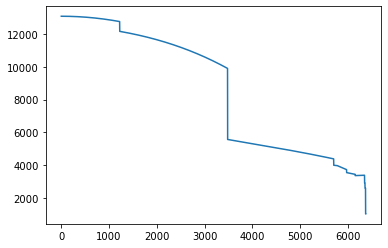

In [6]:

fig, ax = plt.subplots()

rs = np.arange(0, 6371, 0.5)
ax.plot(rs, prem.density(rs))

plt.show()

In [7]:
density_params[:,1]

array([ 0.        , -0.1983676 , -1.01649663, -1.01649663, -1.01649663,
       -0.23286768, -1.26036729, -0.597159  ,  0.10867996,  0.10867996,
        0.        ,  0.        ,  0.        ])

In [8]:
prem_density_antideriv = prem.density_poly.antiderivative()


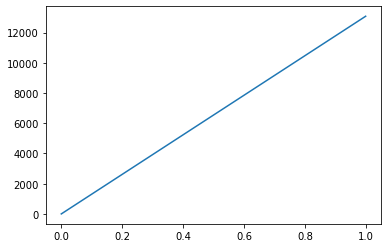

In [9]:
fig, ax = plt.subplots()

rs = np.arange(0, 1, 0.001)
ax.plot(rs, prem_density_antideriv(rs))

plt.show()



In [10]:
prem_density_deriv = prem.density_poly.derivative()


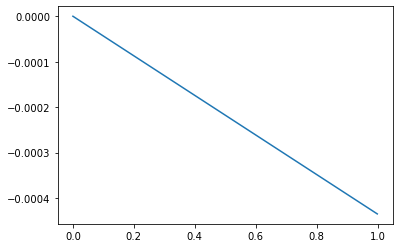

In [11]:
fig, ax = plt.subplots()

rs = np.arange(0, 1, 0.001)
ax.plot(rs, prem_density_deriv(rs))

plt.show()

In [12]:
r2_params = np.array([[0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3]])

# All 14 discontiuities in PREM in km.
r2_breakpoints = np.array([0.0, 1221.5, 3480.0, 3630.0, 5600.0, 5701.0, 5771.0,
                        5971.0, 6151.0, 6291.0, 6346.6, 6356.0, 6368.0, 6371.0])
r2_poly = PeicewisePolynomial(r2_params, r2_breakpoints)
mass_poly = prem.density_poly.mult(r2_poly) 
mass_poly = mass_poly.antiderivative()
mass_poly.coeffs = mass_poly.coeffs * 4.0 * np.pi

In [13]:
mass = mass_poly.integrate(0.0,6371.0)
print("Mass of earth is: ", mass, "kg")

Mass of earth is:  5.973178452676284e+24 kg


Moment of inertia:

$$I = \frac{2}{3} 4\pi \int_0^{R_{e}} \rho(r) r^4 \,\mathrm{d}r.$$

In [16]:
r4_params = np.array([[0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5],
                      [0.0,  0.0, 0.0, 0.0, 1000.0**5]])

# All 14 discontiuities in PREM in km.
r4_breakpoints = np.array([0.0, 1221.5, 3480.0, 3630.0, 5600.0, 5701.0, 5771.0,
                        5971.0, 6151.0, 6291.0, 6346.6, 6356.0, 6368.0, 6371.0])
r4_poly = PeicewisePolynomial(r4_params, r4_breakpoints)
moi_poly = prem.density_poly.mult(r4_poly) 
moi_poly = moi_poly.antiderivative()
moi_poly.coeffs = moi_poly.coeffs * 4.0 * (2/3) * np.pi # integrating this gives MOI 

In [19]:


moi = moi_poly.integrate(0.0,6371.0)
print("Earth's moment of inertia is: ", moi, "kg m^2")
print("I/MR**2:", moi / (mass*(6371*1000)**2))

Earth's moment of inertia is:  8.020207731256643e+37 kg m^2
I/MR**2: 0.3307995553696299


In [38]:
G = 6.6743E-11

r2_params = np.array([[0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3],
                      [0,  0.0000, 1000.0**3]])

g_coefs = np.zeros((mass_poly.coeffs.shape[0], mass_poly.coeffs.shape[1]))
for seg in range(r2_params.shape[0]):
    quo, rem = np.polynomial.polynomial.polydiv(mass_poly.coeffs[seg,:]*G, r2_params[seg,:])
    g_coefs[seg,:quo.size] = quo
    assert rem == 0, "What do I do with this?"
    
#g_coefs = g_coefs * G

g_poly = PeicewisePolynomial(g_coefs, r2_breakpoints)
g_poly = mass_poly.antiderivative()


In [39]:
g_surf = g_poly.integrate(0.0,6371.0)
print("Surface g", g_surf)

Surface g 9.653912132880384e+27


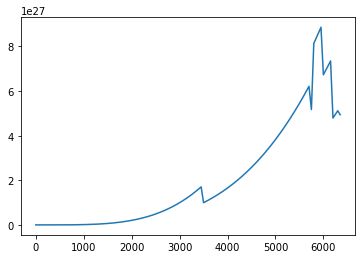

In [40]:
fig, ax = plt.subplots()

rs = np.arange(0, 6371.0, 50)
ax.plot(rs, g_poly(rs))

plt.show()

$$g(r) = \int_0^r \frac{G M(r)}{r^2} \,\mathrm{d}r $$

$$P(r) = \int_{R_e}^r -g(r) \rho(r) \,\mathrm{d}r $$